Installation des different pacakge plus mise en place du seed

In [5]:
set.seed(123)

In [2]:
install.packages("caret")
library(caret)
install.packages("tidyverse")
library(tidyverse)
install.packages("corrplot")
library(corrplot)


Les packages binaires t'el'echarg'es sont dans
	/var/folders/7j/n3q0pxkj3fvc8pf6rq5cpq680000gn/T//Rtmp97wQ4o/downloaded_packages


Le chargement a n'ecessit'e le package : ggplot2

Le chargement a n'ecessit'e le package : lattice




Les packages binaires t'el'echarg'es sont dans
	/var/folders/7j/n3q0pxkj3fvc8pf6rq5cpq680000gn/T//Rtmp97wQ4o/downloaded_packages


-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.2     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.0
v lubridate 1.9.2     v tibble    3.2.1
v purrr     1.0.1     v tidyr     1.3.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
x purrr::lift()   masks caret::lift()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors



Les packages binaires t'el'echarg'es sont dans
	/var/folders/7j/n3q0pxkj3fvc8pf6rq5cpq680000gn/T//Rtmp97wQ4o/downloaded_packages


corrplot 0.92 loaded



Chargement des different datasets 

In [3]:
train <- read.csv("Richters_Predictor_Modeling_Earthquake_Damage_-_Train_Values.csv")
label <- read.csv("Richters_Predictor_Modeling_Earthquake_Damage_-_Train_Labels.csv")
test <- read.csv("Richters_Predictor_Modeling_Earthquake_Damage_-_Test_Values.csv")
trainMerged <- inner_join(train, label, by='building_id')

In [73]:
head(test)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,300051,17,596,11307,3,20,7,6,t,r,...,0,0,0,0,0,0,0,0,0,0
2,99355,6,141,11987,2,25,13,5,t,r,...,1,0,0,0,0,0,0,0,0,0
3,890251,22,19,10044,2,5,4,5,t,r,...,0,0,0,0,0,0,0,0,0,0
4,745817,26,39,633,1,0,19,3,t,r,...,0,0,1,0,0,0,0,0,0,0
5,421793,17,289,7970,3,15,8,7,t,r,...,0,0,0,0,0,0,0,0,0,0
6,871976,22,170,4029,1,55,4,3,t,r,...,0,0,0,0,0,0,0,0,0,0


Question 1 
Preprocessing 

In [4]:
dim(train)
dim(label)
dim(test)
dim(trainMerged)

[1] 260601     39

[1] 260601      2

[1] 86868    39

[1] 260601     40

In [8]:
summary(train)
summary(label)
summary(test)

  building_id      geo_level_1_id geo_level_2_id   geo_level_3_id 
 Min.   :      4   Min.   : 0.0   Min.   :   0.0   Min.   :    0  
 1st Qu.: 261190   1st Qu.: 7.0   1st Qu.: 350.0   1st Qu.: 3073  
 Median : 525757   Median :12.0   Median : 702.0   Median : 6270  
 Mean   : 525676   Mean   :13.9   Mean   : 701.1   Mean   : 6258  
 3rd Qu.: 789762   3rd Qu.:21.0   3rd Qu.:1050.0   3rd Qu.: 9412  
 Max.   :1052934   Max.   :30.0   Max.   :1427.0   Max.   :12567  
 count_floors_pre_eq      age         area_percentage   height_percentage
 Min.   :1.00        Min.   :  0.00   Min.   :  1.000   Min.   : 2.000   
 1st Qu.:2.00        1st Qu.: 10.00   1st Qu.:  5.000   1st Qu.: 4.000   
 Median :2.00        Median : 15.00   Median :  7.000   Median : 5.000   
 Mean   :2.13        Mean   : 26.54   Mean   :  8.018   Mean   : 5.434   
 3rd Qu.:2.00        3rd Qu.: 30.00   3rd Qu.:  9.000   3rd Qu.: 6.000   
 Max.   :9.00        Max.   :995.00   Max.   :100.000   Max.   :32.000   
 land_surface

  building_id       damage_grade  
 Min.   :      4   Min.   :1.000  
 1st Qu.: 261190   1st Qu.:2.000  
 Median : 525757   Median :2.000  
 Mean   : 525676   Mean   :2.238  
 3rd Qu.: 789762   3rd Qu.:3.000  
 Max.   :1052934   Max.   :3.000  

  building_id      geo_level_1_id  geo_level_2_id   geo_level_3_id 
 Min.   :      7   Min.   : 0.00   Min.   :   0.0   Min.   :    0  
 1st Qu.: 264422   1st Qu.: 7.00   1st Qu.: 350.0   1st Qu.: 3073  
 Median : 526984   Median :12.00   Median : 709.0   Median : 6276  
 Mean   : 526628   Mean   :13.89   Mean   : 704.1   Mean   : 6262  
 3rd Qu.: 789084   3rd Qu.:21.00   3rd Qu.:1054.0   3rd Qu.: 9416  
 Max.   :1052923   Max.   :30.00   Max.   :1427.0   Max.   :12567  
 count_floors_pre_eq      age         area_percentage  height_percentage
 Min.   :1.000       Min.   :  0.00   Min.   : 1.000   Min.   : 2.000   
 1st Qu.:2.000       1st Qu.: 10.00   1st Qu.: 5.000   1st Qu.: 4.000   
 Median :2.000       Median : 15.00   Median : 7.000   Median : 5.000   
 Mean   :2.133       Mean   : 26.55   Mean   : 8.014   Mean   : 5.436   
 3rd Qu.:2.000       3rd Qu.: 30.00   3rd Qu.: 9.000   3rd Qu.: 6.000   
 Max.   :8.000       Max.   :995.00   Max.   :92.000   Max.   :32.000   
 land_surface

Bonne nouvelle aucune msiing values est a déclarer 

Mais un certain nombre de variable sont categorielle cela risque d'êtres mauvais pour les etape suivante du projet donc noux allons utilser le one hot encoding afin de les rendre numerique 

Etape 1 : on detecte les variable a modifier 

In [9]:
character_variables_bool<-sapply(trainMerged[1,],class)=="character"
character_variables_bool

building_id                         geo_level_1_id 
                                 FALSE                                  FALSE 
                        geo_level_2_id                         geo_level_3_id 
                                 FALSE                                  FALSE 
                   count_floors_pre_eq                                    age 
                                 FALSE                                  FALSE 
                       area_percentage                      height_percentage 
                                 FALSE                                  FALSE 
                land_surface_condition                        foundation_type 
                                  TRUE                                   TRUE 
                             roof_type                      ground_floor_type 
                                  TRUE                                   TRUE 
                      other_floor_type                               position 
                                  TRUE                                   TRUE 
                    plan_configuration           has_superstructure_adobe_mud 
                                  TRUE                                  FALSE 
   has_superstructure_mud_mortar_stone          has_superstructure_stone_flag 
                                 FALSE                                  FALSE 
has_superstructure_cement_mortar_stone    has_superstructure_mud_mortar_brick 
                                 FALSE                                  FALSE 
has_superstructure_cement_mortar_brick              has_superstructure_timber 
                                 FALSE                                  FALSE 
             has_superstructure_bamboo   has_superstructure_rc_non_engineered 
                                 FALSE                                  FALSE 
      has_superstructure_rc_engineered               has_superstructure_other 
                                 FALSE                                  FALSE 
                legal_ownership_status                         count_families 
                                  TRUE                                  FALSE 
                     has_secondary_use          has_secondary_use_agriculture 
                                 FALSE                                  FALSE 
               has_secondary_use_hotel               has_secondary_use_rental 
                                 FALSE                                  FALSE 
         has_secondary_use_institution               has_secondary_use_school 
                                 FALSE                                  FALSE 
            has_secondary_use_industry          has_secondary_use_health_post 
                                 FALSE                                  FALSE 
          has_secondary_use_gov_office           has_secondary_use_use_police 
                                 FALSE                                  FALSE 
               has_secondary_use_other                           damage_grade 
                                 FALSE                                  FALSE

In [12]:
character_variables <- which(sapply(trainMerged[1,],class)=="character")
character_variables
length(character_variables)

land_surface_condition        foundation_type              roof_type 
                     9                     10                     11 
     ground_floor_type       other_floor_type               position 
                    12                     13                     14 
    plan_configuration legal_ownership_status 
                    15                     27

[1] 8

In [13]:
data_preprocessed<-trainMerged[,-character_variables]
dim(data_preprocessed)


[1] 260601     32

Etape 2 : On applique le one hot encoding pour ces variables

In [14]:
cols_to_transform <- c("land_surface_condition", "foundation_type", "roof_type",
                       "ground_floor_type", "other_floor_type", "position", 
                       "plan_configuration", "legal_ownership_status")

one_hot_trans <- dummyVars(formula = ~ ., data = trainMerged[, cols_to_transform])

data_one_hot <- data.frame(predict(one_hot_trans, newdata = trainMerged))

Etape 3 : On fusionne nos varibale modifer avec notre dataset afin d'obtenir un table avec seulement des valeur numeriques

In [16]:
trainCleaned <- cbind(data_preprocessed, data_one_hot)


On rerire aussi la varibles building_id qui n'apportera rien durant les étape qui vont suivre

In [17]:
trainCleaned <- trainCleaned %>% relocate(damage_grade, .after = legal_ownership_statusw)
trainCleaned <- select(trainCleaned, -c(building_id))
head(trainCleaned)

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,...,plan_configurationn,plan_configurationo,plan_configurationq,plan_configurations,plan_configurationu,legal_ownership_statusa,legal_ownership_statusr,legal_ownership_statusv,legal_ownership_statusw,damage_grade
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,6,487,12198,2,30,6,5,1,1,0,...,0,0,0,0,0,0,0,1,0,3
2,8,900,2812,2,10,8,7,0,1,0,...,0,0,0,0,0,0,0,1,0,2
3,21,363,8973,2,10,5,5,0,1,0,...,0,0,0,0,0,0,0,1,0,3
4,22,418,10694,2,10,6,5,0,1,0,...,0,0,0,0,0,0,0,1,0,2
5,11,131,1488,3,30,8,9,1,0,0,...,0,0,0,0,0,0,0,1,0,3
6,8,558,6089,2,10,9,5,0,1,0,...,0,0,0,0,0,0,0,1,0,2


Afin da'voir une premiere vision des correlation entre les varaible nous mettons en place une matrice de correlation 

In [22]:
numeric_data = c()
for (i in 1:ncol(trainCleaned)) {
    if (class(trainCleaned[, i]) != "character") {
        numeric_data <- append(numeric_data, i)
    }
}
cormat <- abs(cor(trainCleaned[, numeric_data]))
cormat

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,...,plan_configurationn,plan_configurationo,plan_configurationq,plan_configurations,plan_configurationu,legal_ownership_statusa,legal_ownership_statusr,legal_ownership_statusv,legal_ownership_statusw,damage_grade
geo_level_1_id,1.0000000000,0.0614048534,0.0027184451,0.089363579,0.003907635,0.0711581503,0.063474054,0.018245465,0.152037764,0.0076772072,...,8.222888e-04,0.0081792905,0.0093826688,0.0085588975,0.0330521678,0.1003929898,0.0078735782,0.0820548764,0.0046460055,0.072346634
geo_level_2_id,0.0614048534,1.0000000000,0.0009210931,0.047729694,0.012593841,0.0494432851,0.035516389,0.015832855,0.076491325,0.0087428232,...,4.151702e-04,0.0057857317,0.0043257875,0.0059284248,0.0255317097,0.0258932511,0.0270114837,0.0231892461,0.0135791615,0.043160757
geo_level_3_id,0.0027184451,0.0009210931,1.0000000000,0.021646316,0.006384587,0.0056426426,0.024506767,0.015732164,0.026294351,0.0195789298,...,3.123084e-03,0.0028035078,0.0018949999,0.0033985366,0.0032398945,0.0341990799,0.0013094153,0.0185331138,0.0130999509,0.007931779
count_floors_pre_eq,0.0893635793,0.0477296944,0.0216463160,1.000000000,0.086668031,0.1010711767,0.772734385,0.174851702,0.027115976,0.0410575457,...,2.651229e-03,0.0011476617,0.0331697188,0.0033141212,0.0048632406,0.0968661322,0.0082357340,0.0732731967,0.0070463940,0.122308494
age,0.0039076350,0.0125938406,0.0063845871,0.086668031,1.000000000,0.0043225113,0.061073549,0.068032466,0.001321263,0.0091287713,...,1.461564e-03,0.0009169155,0.0016763126,0.0010114978,0.0036296854,0.0239280619,0.0010548545,0.0166966229,0.0036422654,0.029273302
area_percentage,0.0711581503,0.0494432851,0.0056426426,0.101071177,0.004322511,1.0000000000,0.196645285,0.026286747,0.225540553,0.0004726122,...,3.568111e-03,0.0356325668,0.0166477585,0.0191642308,0.0961701006,0.0282488709,0.0153428904,0.0292612123,0.0031133554,0.125220516
height_percentage,0.0634740542,0.0355163893,0.0245067672,0.772734385,0.061073549,0.1966452848,1.000000000,0.149725170,0.106572989,0.0202600396,...,2.732364e-03,0.0066370928,0.0164955225,0.0001258120,0.0061965183,0.0788515447,0.0086931388,0.0630496531,0.0008372311,0.048130024
has_superstructure_adobe_mud,0.0182454652,0.0158328554,0.0157321636,0.174851702,0.068032466,0.0262867471,0.149725170,1.000000000,0.306861168,0.0069617504,...,1.530135e-03,0.0027853664,0.0173120256,0.0053125257,0.0190196841,0.0301759065,0.0251080746,0.0046808661,0.0331649780,0.055313602
has_superstructure_mud_mortar_stone,0.1520377636,0.0764913251,0.0262943509,0.027115976,0.001321263,0.2255405528,0.106572989,0.306861168,1.000000000,0.0340455999,...,3.467759e-05,0.0208515104,0.0509111924,0.0174759834,0.0985564267,0.1387459777,0.0478715860,0.1266407426,0.0037261188,0.291325239
has_superstructure_stone_flag,0.0076772072,0.0087428232,0.0195789298,0.041057546,0.009128771,0.0004726122,0.020260040,0.006961750,0.034045600,1.0000000000,...,5.316792e-04,0.0055826154,0.0117625293,0.0035426230,0.0095558954,0.0083835268,0.0049394746,0.0055453273,0.0052446171,0.066039449


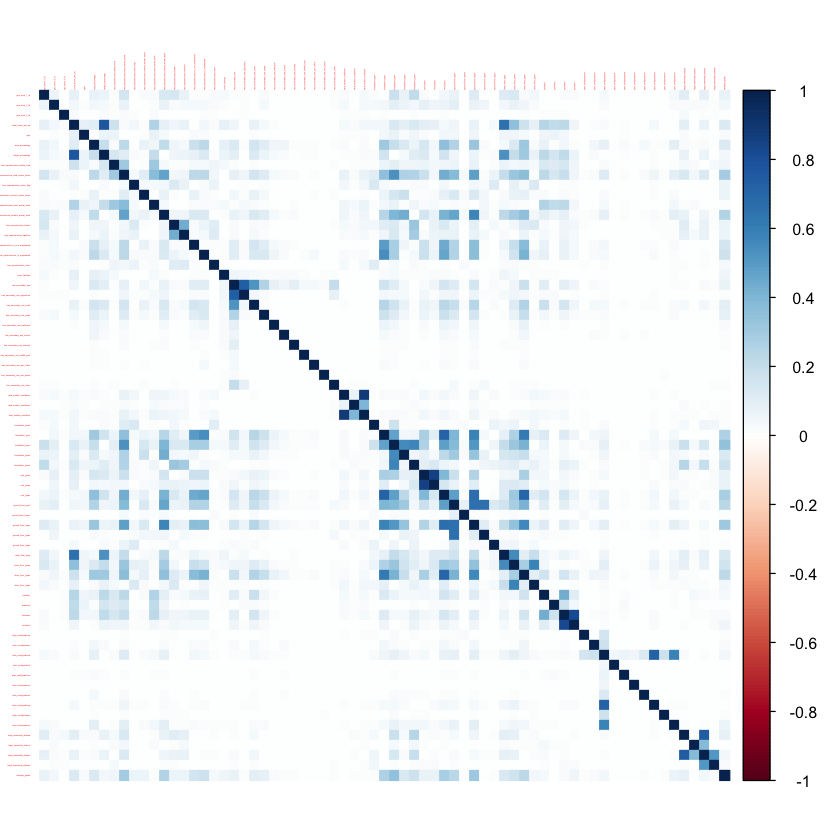

In [23]:
cormat <- abs(cor(trainCleaned))
corrplot(cormat, tl.cex = 0.1, method = "color")


In [90]:
to_delete_DG = c()
for (i in 1:(nrow(cormat)-1)) {
    for (j in i:(nrow(cormat)-1)) {
        if (cormat[i,j] > 0.5 &  i!=j) {
            if (abs(cormat[i,69]) < abs(cormat[j,69])) {
                to_delete_DG <- c(to_delete_DG, i)
            } else {
                to_delete_DG <- c(to_delete_DG, j)
            }
        }
    }
}
to_delete_DG <- to_delete_DG[!duplicated(to_delete_DG)]

to_delete_DG


[1]  7  4  9 13 17 21 20 31 35 49 37 38 44 40 41 42 45 47 50 53 62 57 67 68

In [239]:
for (i in 1:(nrow(cormat)-1)) {
    if (cormat[i, 68] < 0.01) {
        to_delete_DG <- c(to_delete_DG, i)
    }
}
to_delete_DG <- to_delete_DG[!duplicated(to_delete_DG)]
to_delete_DG


[1]  8  5 10 45 17 36 22 21 32 38 37 40 42 50 43 46 49 51 55 58 65 66 69  1  3
[26]  4  6  7  9 11 12 13 14 18 19 20 23 24 25 26 27 28 29 30 31 33 34 35 41 44
[51] 47 52 53 54 56 57 59 60 61 62 63 64  2 15 16 48

In [91]:
trainCleanedD <- select(trainCleaned,-c(to_delete_DG))
head(trainCleanedD)

,geo_level_1_id,geo_level_2_id,geo_level_3_id,age,area_percentage,has_superstructure_adobe_mud,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_timber,...,plan_configurationc,plan_configurationf,plan_configurationm,plan_configurationn,plan_configurationo,plan_configurations,plan_configurationu,legal_ownership_statusa,legal_ownership_statusr,damage_grade
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,6,487,12198,30,6,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2,8,900,2812,10,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,21,363,8973,10,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,22,418,10694,10,6,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2
5,11,131,1488,30,8,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
6,8,558,6089,10,9,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


Input and output varaibles 

In [92]:


X<-trainCleanedD[,setdiff(colnames(trainCleanedD),"damage_grade")]
Y<-trainCleanedD[,"damage_grade"]


N <-nrow(X)
n <-ncol(X)

In [93]:
N
n

[1] 260601

[1] 44

In [94]:
mean(Y)

[1] 2.238272

In [95]:
var(Y)

[1] 0.3743159

In [57]:
# drop = F is used to preserve the structure of the data as data.frame (see https://www.r-bloggers.com/2018/02/r-tip-use-drop-false-with-data-frames/)
CV_folds <- 10

size_CV <-floor(N/CV_folds)

CV_err<-matrix(0,nrow=n,ncol=CV_folds)

for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X[idx_tr,]
    Y_tr<-Y[idx_tr]                          
    
    # Compute correlation across all the input variables and the target variable
    correlation_vector <-abs(cor(X_tr,Y_tr))
    # Rank variables according to correlation with the output
    correlation_ranking_idx <-sort(correlation_vector,dec=T,index.return=T)$ix
     
    for (nb_features in 1:n) {
        # Create a dataset including only the nb_features most correlated variables with the output
        DS<-cbind(X_tr[,correlation_ranking_idx[1:nb_features],drop=F],damage_grade=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(damage_grade~.,DS)
        
        # Model prediction
        Y_hat_ts<- predict(model,X_ts[,correlation_ranking_idx[1:nb_features],drop=F])
        
        # Cross validation error = MSE
        CV_err[nb_features,i] <- mean((Y_hat_ts-Y_ts)^2)
    }
}  

print(paste("#Features: ",c(1:n)," ; CV error=",round(apply(CV_err,1,mean),digits=4), " ; std dev=",round(apply(CV_err,1,sd),digits=4)))

 [1] "#Features:  1  ; CV error= 0.3302  ; std dev= 0.0022" 
 [2] "#Features:  2  ; CV error= 0.3199  ; std dev= 0.0019" 
 [3] "#Features:  3  ; CV error= 0.3174  ; std dev= 0.0019" 
 [4] "#Features:  4  ; CV error= 0.3169  ; std dev= 0.0019" 
 [5] "#Features:  5  ; CV error= 0.3161  ; std dev= 0.0018" 
 [6] "#Features:  6  ; CV error= 0.3146  ; std dev= 0.0019" 
 [7] "#Features:  7  ; CV error= 0.3146  ; std dev= 0.0018" 
 [8] "#Features:  8  ; CV error= 0.3138  ; std dev= 0.0018" 
 [9] "#Features:  9  ; CV error= 0.3134  ; std dev= 0.0018" 
[10] "#Features:  10  ; CV error= 0.3127  ; std dev= 0.0019"
[11] "#Features:  11  ; CV error= 0.3126  ; std dev= 0.0019"
[12] "#Features:  12  ; CV error= 0.3126  ; std dev= 0.0019"
[13] "#Features:  13  ; CV error= 0.3125  ; std dev= 0.0019"
[14] "#Features:  14  ; CV error= 0.3124  ; std dev= 0.0018"
[15] "#Features:  15  ; CV error= 0.312  ; std dev= 0.0016" 
[16] "#Features:  16  ; CV error= 0.3116  ; std dev= 0.0017"
[17] "#Features:  17  ; 

In [58]:
NuF1 <- correlation_ranking_idx
NaF1 <- colnames(X)[correlation_ranking_idx]
NuF1
NaF1

[1] 31 36  7 11 15 33 39 14 32 38  5 19 20 53 34 18  1 12  8 13 52  9 17  6 43
[26] 40 46  2 41 16 55  4 21 45 44 35 37 27 29 28 30 10 50 23 51 22 25 24  3 48
[51] 42 54 49 26 47

[1] "foundation_typer"                      
 [2] "ground_floor_typev"                    
 [3] "has_superstructure_mud_mortar_stone"   
 [4] "has_superstructure_cement_mortar_brick"
 [5] "has_superstructure_rc_engineered"      
 [6] "foundation_typew"                      
 [7] "other_floor_typeq"                     
 [8] "has_superstructure_rc_non_engineered"  
 [9] "foundation_typeu"                      
[10] "other_floor_typej"                     
[11] "area_percentage"                       
[12] "has_secondary_use_hotel"               
[13] "has_secondary_use_rental"              
[14] "legal_ownership_statusa"               
[15] "roof_typen"                            
[16] "has_secondary_use"                     
[17] "geo_level_1_id"                        
[18] "has_superstructure_timber"             
[19] "has_superstructure_stone_flag"         
[20] "has_superstructure_bamboo"             
[21] "plan_configurationu"                   
[22] "has_superstructure_cement_mortar_stone"
[23] "count_families"                        
[24] "has_superstructure_adobe_mud"          
[25] "positiont"                             
[26] "other_floor_typex"                     
[27] "plan_configurationd"                   
[28] "geo_level_2_id"                        
[29] "positionj"                             
[30] "has_superstructure_other"              
[31] "legal_ownership_statusw"               
[32] "age"                                   
[33] "has_secondary_use_institution"         
[34] "plan_configurationc"                   
[35] "plan_configurationa"                   
[36] "ground_floor_typem"                    
[37] "ground_floor_typez"                    
[38] "has_secondary_use_other"               
[39] "land_surface_conditiont"               
[40] "land_surface_conditiono"               
[41] "foundation_typeh"                      
[42] "has_superstructure_mud_mortar_brick"   
[43] "plan_configurationo"                   
[44] "has_secondary_use_industry"            
[45] "plan_configurations"                   
[46] "has_secondary_use_school"              
[47] "has_secondary_use_gov_office"          
[48] "has_secondary_use_health_post"         
[49] "geo_level_3_id"                        
[50] "plan_configurationm"                   
[51] "positiono"                             
[52] "legal_ownership_statusr"               
[53] "plan_configurationn"                   
[54] "has_secondary_use_use_police"          
[55] "plan_configurationf"

In [96]:
# drop = F is used to preserve the structure of the data as data.frame (see https://www.r-bloggers.com/2018/02/r-tip-use-drop-false-with-data-frames/)

CV_folds <- 10

size_CV <-floor(N/CV_folds)

CV_err<-matrix(0,nrow=n,ncol=CV_folds)

for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X[idx_tr,]
    Y_tr<-Y[idx_tr]                          
    
    # Computing the correlation between input variables and output variable on the training set
    correlation<-abs(cor(X_tr,Y_tr))
    
    # Initialization : No variables are selected and all the variables are candidates
    selected<-c()
    candidates<-1:n
    
    #mRMR ranks the variables by taking account not only the correlation with the output, but also by avoiding redudant variables
    for (j in 1:n) {
        redundancy_score<-numeric(length(candidates))
        
        if (length(selected)>0) {
            # Compute the correlation between the selected variables and the candidates on the training set
            cor_selected_candidates<-cor(X_tr[,selected,drop=F],X_tr[,candidates,drop=F])
            # Compute the mean correlation for each candidate variable, across the selected variables
            redundancy_score<-apply(cor_selected_candidates,2,mean)
        }
        
        # mRMR: minimum Redundancy Maximum Relevancy
        mRMR_score<-correlation[candidates]-redundancy_score
        
        # Select the candidate variable that maximises the mRMR score
        selected_current<-candidates[which.max(mRMR_score)]
        selected<-c(selected,selected_current)
        
        # Remove the selected variables from the candidates
        candidates<-setdiff(candidates,selected_current)
    }
    
    ranking <- selected
     
    for (nb_features in 1:n) {
        # Create a dataset including only the first nb_features selected variables
        DS<-cbind(X_tr[,ranking[1:nb_features],drop=F],damage_grade=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(damage_grade~.,DS)
        
        # Model prediction
        Y_hat_ts<- predict(model,X_ts[,ranking[1:nb_features],drop=F])
        
        # Cross-validation error = MSE
        CV_err[nb_features,i]<-mean((Y_hat_ts-Y_ts)^2)
    }
}  

print(paste("#Features: ",c(1:n)," ; CV error=",round(apply(CV_err,1,mean),digits=4), " ; std dev=",round(apply(CV_err,1,sd),digits=4)))

 [1] "#Features:  1  ; CV error= 0.3302  ; std dev= 0.0022" 
 [2] "#Features:  2  ; CV error= 0.3288  ; std dev= 0.002"  
 [3] "#Features:  3  ; CV error= 0.3286  ; std dev= 0.002"  
 [4] "#Features:  4  ; CV error= 0.3276  ; std dev= 0.002"  
 [5] "#Features:  5  ; CV error= 0.3267  ; std dev= 0.002"  
 [6] "#Features:  6  ; CV error= 0.3264  ; std dev= 0.002"  
 [7] "#Features:  7  ; CV error= 0.3261  ; std dev= 0.0019" 
 [8] "#Features:  8  ; CV error= 0.326  ; std dev= 0.0019"  
 [9] "#Features:  9  ; CV error= 0.3254  ; std dev= 0.0018" 
[10] "#Features:  10  ; CV error= 0.3254  ; std dev= 0.0018"
[11] "#Features:  11  ; CV error= 0.3235  ; std dev= 0.0017"
[12] "#Features:  12  ; CV error= 0.3232  ; std dev= 0.0018"
[13] "#Features:  13  ; CV error= 0.3232  ; std dev= 0.0018"
[14] "#Features:  14  ; CV error= 0.3222  ; std dev= 0.0019"
[15] "#Features:  15  ; CV error= 0.3215  ; std dev= 0.0019"
[16] "#Features:  16  ; CV error= 0.3212  ; std dev= 0.0019"
[17] "#Features:  17  ; 

In [97]:
NuF2 <- selected
NaF2 <- colnames(X)[selected]
NuF2
NaF2

[1] 27 12 43 31  5 10 15 28 16  1  7 42  8 34 14  2 11  6 17 25 24  4 35 36 23
[26] 32 13 29 30 40 19 41 18 21 20 26  3 38 39 44 22 37 33  9

[1] "foundation_typer"                      
 [2] "has_superstructure_rc_non_engineered"  
 [3] "legal_ownership_statusa"               
 [4] "other_floor_typeq"                     
 [5] "area_percentage"                       
 [6] "has_superstructure_timber"             
 [7] "has_secondary_use_hotel"               
 [8] "roof_typen"                            
 [9] "has_secondary_use_rental"              
[10] "geo_level_1_id"                        
[11] "has_superstructure_stone_flag"         
[12] "plan_configurationu"                   
[13] "has_superstructure_cement_mortar_stone"
[14] "positiont"                             
[15] "count_families"                        
[16] "geo_level_2_id"                        
[17] "has_superstructure_bamboo"             
[18] "has_superstructure_adobe_mud"          
[19] "has_secondary_use_institution"         
[20] "land_surface_conditiont"               
[21] "land_surface_conditiono"               
[22] "age"                                   
[23] "plan_configurationa"                   
[24] "plan_configurationc"                   
[25] "has_secondary_use_other"               
[26] "positionj"                             
[27] "has_superstructure_other"              
[28] "ground_floor_typem"                    
[29] "ground_floor_typez"                    
[30] "plan_configurationo"                   
[31] "has_secondary_use_industry"            
[32] "plan_configurations"                   
[33] "has_secondary_use_school"              
[34] "has_secondary_use_gov_office"          
[35] "has_secondary_use_health_post"         
[36] "foundation_typeh"                      
[37] "geo_level_3_id"                        
[38] "plan_configurationm"                   
[39] "plan_configurationn"                   
[40] "legal_ownership_statusr"               
[41] "has_secondary_use_use_police"          
[42] "plan_configurationf"                   
[43] "positiono"                             
[44] "has_superstructure_mud_mortar_brick"

In [62]:
# drop = F is used to preserve the structure of the data as data.frame (see https://www.r-bloggers.com/2018/02/r-tip-use-drop-false-with-data-frames/)
CV_folds <- 10

size_CV <-floor(N/CV_folds)

CV_err<-matrix(0,nrow=n,ncol=CV_folds)

# Compute PCA on the full input dataset X and return the dataset transformed in the space of principal components
X_pca<-data.frame(prcomp(X,retx=T)$x)

for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X_pca[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X_pca[idx_tr,]
    Y_tr<-Y[idx_tr]         
     
    for (nb_components in 1:n) {
        # Create a dataset including only the first nb_components principal components
        DS<-cbind(X_tr[,1:nb_components,drop=F],damage_grade=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(damage_grade~.,DS)
        
        # Model predict
        Y_hat_ts<- predict(model,X_ts[,1:nb_components,drop=F])
        
        CV_err[nb_components,i]<-mean((Y_hat_ts-Y_ts)^2)
    }
}  

print(paste("#Features: ",c(1:n)," ; CV error=",round(apply(CV_err,1,mean),digits=4), " ; std dev=",round(apply(CV_err,1,sd),digits=4)))


 [1] "#Features:  1  ; CV error= 0.3743  ; std dev= 0.0018" 
 [2] "#Features:  2  ; CV error= 0.3736  ; std dev= 0.0018" 
 [3] "#Features:  3  ; CV error= 0.3733  ; std dev= 0.0018" 
 [4] "#Features:  4  ; CV error= 0.3713  ; std dev= 0.0019" 
 [5] "#Features:  5  ; CV error= 0.366  ; std dev= 0.0022"  
 [6] "#Features:  6  ; CV error= 0.3329  ; std dev= 0.0019" 
 [7] "#Features:  7  ; CV error= 0.3269  ; std dev= 0.0021" 
 [8] "#Features:  8  ; CV error= 0.3259  ; std dev= 0.0021" 
 [9] "#Features:  9  ; CV error= 0.3212  ; std dev= 0.0019" 
[10] "#Features:  10  ; CV error= 0.32  ; std dev= 0.002"   
[11] "#Features:  11  ; CV error= 0.3177  ; std dev= 0.0021"
[12] "#Features:  12  ; CV error= 0.3177  ; std dev= 0.0021"
[13] "#Features:  13  ; CV error= 0.3173  ; std dev= 0.0022"
[14] "#Features:  14  ; CV error= 0.3133  ; std dev= 0.0019"
[15] "#Features:  15  ; CV error= 0.313  ; std dev= 0.002"  
[16] "#Features:  16  ; CV error= 0.3128  ; std dev= 0.0019"
[17] "#Features:  17  ; 

In [84]:
# drop = F is used to preserve the structure of the data as data.frame (see https://www.r-bloggers.com/2018/02/r-tip-use-drop-false-with-data-frames/)
CV_folds <- 10

size_CV <-floor(N/CV_folds)

selected<-NULL

# Perform up to n (number of variables) round of selection
for (round in 1:n) { 
    candidates<-setdiff(1:n,selected)
    
    CV_err<-matrix(0,nrow=length(candidates),ncol=CV_folds)
    
    # For each round, test all the candidate variables
    for (j in 1:length(candidates)) {
        features_to_include<-c(selected,candidates[j])
        
        # For each variable, perform cross-validation to determine the CV-error
        for (i in 1:CV_folds) {
            
            idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
            X_ts<-X[idx_ts,features_to_include,drop=F]  
            Y_ts<-Y[idx_ts]  
     
            idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
            X_tr<-X[idx_tr,features_to_include,drop=F]
            Y_tr<-Y[idx_tr]         
            
            # Create a dataset including only the first nb_components principal components
            DS<-cbind(X_tr,damage_grade=Y_tr)
        
            # Model fit (using lm function)
            model<- lm(damage_grade~.,DS)
        
            # Model predict
            Y_hat_ts<- predict(model,X_ts)
     
            # Cross validation error = MSE
            CV_err[j,i]<-mean((Y_hat_ts-Y_ts)^2)
        }
        
    }
    
    # Compute the mean and sd of cross-validation error across all the candidates
    # In CV_err matrix, every row represents a candidate, and every element represents the results of the i^th CV fold.
    CV_err_mean<-apply(CV_err,1,mean)
    CV_err_sd<-apply(CV_err,1,sd)
    
    # Select the candiate that minimizes the cross-validation error
    selected_current<-which.min(CV_err_mean)              
    selected<-c(selected,candidates[selected_current])
    
    print(paste("Round ",round," ; Selected feature: ",candidates[selected_current]," ; CV error=",round(CV_err_mean[selected_current],digits=4), " ; std dev=",round(CV_err_sd[selected_current],digits=4)))

}
              

In [ ]:
colnames(X)[selected]

In [98]:
NaF2 <- 32
selected_features <- ranking[1:NaF2] 

New_Train <- trainCleanedD[, selected_features, drop = FALSE]

# Ajoutez la variable cible si nécessaire
New_Train <- cbind(New_Train, damage_grade = Y)


In [99]:
New_Train

,foundation_typer,has_superstructure_rc_non_engineered,legal_ownership_statusa,other_floor_typeq,area_percentage,has_superstructure_timber,has_secondary_use_hotel,roof_typen,has_secondary_use_rental,geo_level_1_id,...,plan_configurationc,has_secondary_use_other,positionj,has_superstructure_other,ground_floor_typem,ground_floor_typez,plan_configurationo,has_secondary_use_industry,plan_configurations,damage_grade
,<dbl>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<int>,<int>,...,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>
1,1,0,0,1,6,0,0,1,0,6,...,0,0,0,0,0,0,0,0,0,3
2,1,0,0,1,8,0,0,1,0,8,...,0,0,0,0,0,0,0,0,0,2
3,1,0,0,0,5,0,0,1,0,21,...,0,0,0,0,0,0,0,0,0,3
4,1,0,0,0,6,1,0,1,0,22,...,0,0,0,0,0,0,0,0,0,2
5,1,0,0,0,8,0,0,1,0,11,...,0,0,0,0,0,0,0,0,0,3
6,1,0,0,1,9,0,0,1,0,8,...,0,0,0,0,0,0,0,0,0,2
7,1,0,0,1,3,0,0,1,0,9,...,0,0,0,0,0,0,0,0,0,3
8,0,0,0,0,8,1,0,0,0,20,...,0,0,0,0,0,0,0,0,0,1
9,1,0,0,1,8,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [100]:
X<-New_Train[,setdiff(colnames(New_Train),"damage_grade")]
Y<-New_Train[,"damage_grade"]


N <-nrow(X)
n <-ncol(X)

Decison Tree

In [66]:
library(rpart) 

In [101]:
DS<-cbind(X,damage_grade=Y)

model<- rpart(damage_grade~.,DS) ### Fill with you code here
        
Y_hat<- predict(model,X)
        
empirical_error<-mean((Y_hat-Y)^2) 

print(paste("Empirical error=",round(empirical_error,digits=4)))

[1] "Empirical error= 0.2736"


In [102]:
length(Y_hat_ts)
length(Y_hat)

[1] 26060

[1] 260601

In [103]:
library(rpart.plot) 

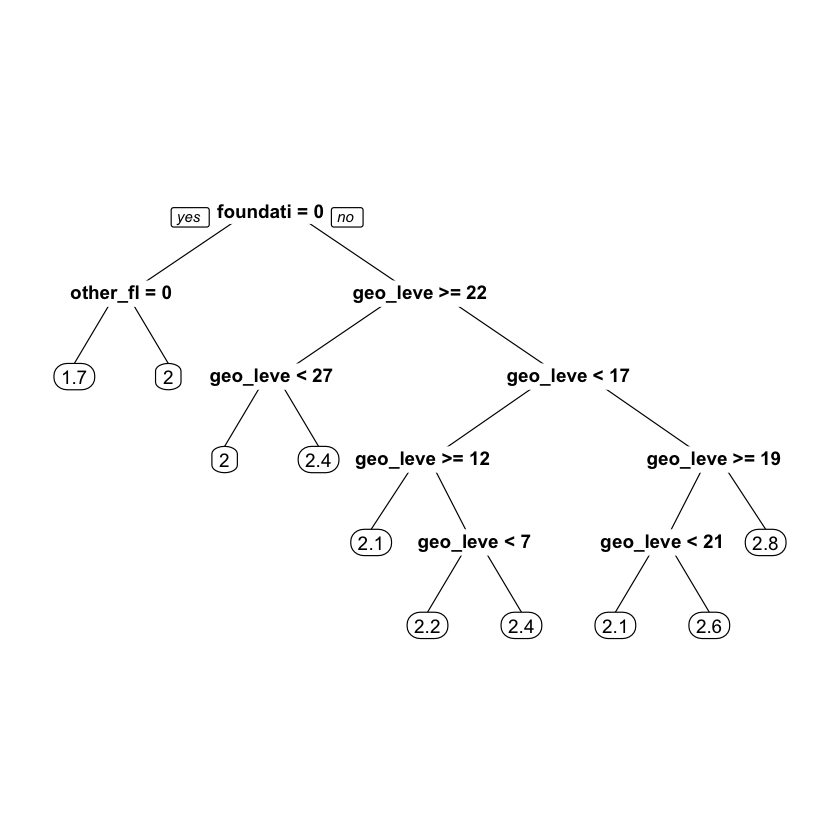

In [104]:
prp(model)

In [83]:
CV_folds <- 10

size_CV <-floor(N/CV_folds)

CV_err<-numeric(CV_folds)

for (i in 1:CV_folds) {
     idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
     X_ts<-X[idx_ts,]  
     Y_ts<-Y[idx_ts]  
     
     idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
     X_tr<-X[idx_tr,]
     Y_tr<-Y[idx_tr]                          
     
     DS<-cbind(X_tr,damage_grade=Y_tr)
    
     # Model fit (using rpart function)
     model<- rpart(damage_grade~.,DS)
     
     # Model prediction 
     Y_hat_ts<- predict(model,X_ts)
     
     # Cross validation error = Mean Squared Error
     CV_err[i]<-mean((Y_hat_ts-Y_ts)^2)
}
    

print(paste("CV error=",round(mean(CV_err),digits=4), " ; std dev=",round(sd(CV_err),digits=4)))

CV_err_rpart_single_model <- CV_err

[1] "CV error= 0.2722  ; std dev= 0.0018"


In [105]:
CV_folds <- 10

size_CV <-floor(N/CV_folds)

CV_err<-numeric(CV_folds)
CV_f1_scores <- numeric(CV_folds)

for (i in 1:CV_folds) {
     idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
     X_ts<-X[idx_ts,]  
     Y_ts<-Y[idx_ts]  
     
     idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
     X_tr<-X[idx_tr,]
     Y_tr<-Y[idx_tr]                          
     
     DS<-cbind(X_tr,damage_grade=Y_tr)
    
     # Model fit (using rpart function)
     model<- rpart(damage_grade~.,DS)
     
     # Model prediction 
     Y_hat_ts<- predict(model,X_ts)

     Y_hat_ts <- as.integer(Y_hat_ts)
     
     # Cross validation error = Mean Squared Error
     CV_err[i]<-mean((Y_hat_ts-Y_ts)^2)
     # Calculer le F1-score
     f1_score <- F1_Score(y_pred = Y_ts, y_true = Y_hat_ts, positive = "1")
     CV_err[i] <- mean((Y_hat_ts - Y_ts)^2)
     CV_f1_scores[i] <- f1_score 
}
    

print(paste("CV error=",round(mean(CV_err),digits=4), " ; std dev=",round(sd(CV_err),digits=4)))
print(paste("F1-score micro-averagé CV =", round(mean(CV_f1_scores), digits = 4), "; écart-type =", round(sd(CV_f1_scores), digits = 4)))

CV_err_rpart_single_model <- CV_err

[1] "CV error= 0.5581  ; std dev= 0.0036"
[1] "F1-score micro-averag<U+00E9> CV = 0.4212 ; <U+00E9>cart-type = 0.0059"


In [113]:
library(e1071)

CV_folds <- 10

size_CV <-floor(N/CV_folds)

CV_err<-numeric(CV_folds)

for (i in 1:CV_folds) {
     idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
     X_ts<-X[idx_ts,]  
     Y_ts<-Y[idx_ts]  
     
     idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
     X_tr<-X[idx_tr,]
     Y_tr<-Y[idx_tr]                          
     
     DS<-cbind(X_tr,damage_grade=Y_tr)
    
     # Model fit (using lm function)
     model<- svm(damage_grade~.,DS)
     
     # Model prediction 
     Y_hat_ts<- predict(model,X_ts)
     
     # Cross validation error = Mean Squared Error
     CV_err[i]<-mean((Y_hat_ts-Y_ts)^2)
}
    

print(paste("CV error=",round(mean(CV_err),digits=4), " ; std dev=",round(sd(CV_err),digits=4)))

CV_err_svm_single_model <- CV_err

In [85]:
install.packages("MLmetrics")


Les packages binaires t'el'echarg'es sont dans
	/var/folders/7j/n3q0pxkj3fvc8pf6rq5cpq680000gn/T//Rtmp97wQ4o/downloaded_packages


In [86]:
library(MLmetrics)

In [111]:
library(nnet)

CV_folds <- 10

size_CV <-floor(N/CV_folds)

CV_err<-numeric(CV_folds)

for (i in 1:CV_folds) {
     idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
     X_ts<-X[idx_ts,]  
     Y_ts<-Y[idx_ts]  
     
     idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
     X_tr<-X[idx_tr,]
     Y_tr<-Y[idx_tr]                          
     
     DS<-cbind(X_tr,damage_grade=Y_tr/10) # The output variable is rescaled to be in 0-1 range
    
     # Model fit (using nnet function)
     model <- nnet(damage_grade ~ .,DS,skip=FALSE,
                       size=10, maxit=5000,trace=F,rang=0.2,MaxNWts=10000)
     
     # Model prediction (multiplied by 10 to rescale (0,1) -> (0,10))
     Y_hat_ts<- predict(model,X_ts)*10

     # Calculate F1 score
     f1 <- F1_Score(y_pred = Y_ts, y_true = Y_hat_ts, positive = "1")
     
     # Cross validation error = Mean Squared Error
     CV_err[i]<-mean((Y_hat_ts-Y_ts)^2)
}
    

print(paste("CV error=",round(mean(CV_err),digits=4), " ; std dev=",round(sd(CV_err),digits=4)))


print(paste("F1 score =", round(f1, digits = 4)))

CV_err_nnet_single_model <- CV_err

[1] "CV error= 3.3495  ; std dev= 2.6306"
[1] "F1 score = NA"


In [107]:
# drop = F is used to preserve the structure of the data as data.frame (see https://www.r-bloggers.com/2018/02/r-tip-use-drop-false-with-data-frames/)

CV_folds <- 10
n_variables <- 10

size_CV <-floor(N/CV_folds)

CV_err<-matrix(0,nrow=n_variables,ncol=CV_folds)

for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X[idx_tr,]
    Y_tr<-Y[idx_tr]                          
    
    # Computing the correlation between input variables and output variable on the training set
    correlation<-abs(cor(X_tr,Y_tr))
    
    # Initialization : No variables are selected and all the variables are candidates
    selected<-c()
    candidates<-1:n
    
    #mRMR ranks the variables by taking account not only the correlation with the output, but also by avoiding redudant variables
    for (j in 1:n_variables) {
        redundancy_score<-numeric(length(candidates))
        
        if (length(selected)>0) {
            # Compute the correlation between the selected variables and the candidates on the training set
            cor_selected_candidates<-cor(X_tr[,selected,drop=F],X_tr[,candidates,drop=F])
            # Compute the mean correlation for each candidate variable, across the selected variables
            redundancy_score<-apply(cor_selected_candidates,2,mean)
        }
        
        # mRMR: minimum Redundancy Maximum Relevancy
        mRMR_score<-correlation[candidates]-redundancy_score
        
        # Select the candidate variable that maximises the mRMR score
        selected_current<-candidates[which.max(mRMR_score)]
        selected<-c(selected,selected_current)
        
        # Remove the selected variables from the candidates
        candidates<-setdiff(candidates,selected_current)
    }
    
    ranking <- selected
     
    for (nb_features in 1:n_variables) {
        # Create a dataset including only the first nb_features selected variables
        # The output variable is rescaled to be in 0-1 range
        DS<-cbind(X_tr[,ranking[1:nb_features],drop=F],damage_grade=Y_tr/10)
        
        # Model fit (using nnet function)
        model <- nnet(damage_grade ~ .,DS,skip=FALSE,
                       size=10, maxit=500,trace=F,rang=0.2,MaxNWts=10000)
     
        # Model prediction (multiplied by 10 to rescale (0,1) -> (0,10))
        Y_hat_ts<- predict(model,X_ts)*10
        
        # Cross-validation error = MSE
        CV_err[nb_features,i]<-mean((Y_hat_ts-Y_ts)^2)
    }
}  

print(paste("#Features: ",c(1:n_variables)," ; CV error=",round(apply(CV_err,1,mean),digits=4), " ; std dev=",round(apply(CV_err,1,sd),digits=4)))

CV_err_nnet_single_model_fs <- CV_err